In [1]:
import numpy as np
import pandas as pd
import pygmo
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from config import MAX_DISCOUNT, FEATURES

%matplotlib inline

# Train a MLP classifier using scikit-learn

In [2]:
df=pd.read_csv('training_data_randn.csv')
cols_x = FEATURES
col_y = 'is_deal'
col_p = 'Probability'
print('Input features of the propensity model\n{}'.format(cols_x))

Input features of the propensity model
['Discount', 'RRP', 'Service', 'Elasticity', 'nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'x_c0', 'x_c1', 'CLV']


In [3]:
n_train = int(0.8*len(df))
x = df[cols_x]
x_train = x[:n_train]
x_test  = x[n_train:]
y_train = df[col_y][:n_train]
y_test = df[col_y][n_train:]
p_train = df[col_p][:n_train]
p_test = df[col_p][n_train:]

In [4]:
scaler = StandardScaler()
mlp = MLPClassifier(hidden_layer_sizes=(32, 16), 
                    activation='relu', 
                    max_iter=20, 
                    batch_size=128, 
                    random_state=1,
                    verbose=True)
model = Pipeline([('scalar', scaler), ('mlp', mlp)])
model.fit(x_train, y_train)


Iteration 1, loss = 0.58885129
Iteration 2, loss = 0.57937233
Iteration 3, loss = 0.57729257
Iteration 4, loss = 0.57643561
Iteration 5, loss = 0.57590963
Iteration 6, loss = 0.57556416
Iteration 7, loss = 0.57532272
Iteration 8, loss = 0.57510127
Iteration 9, loss = 0.57491859
Iteration 10, loss = 0.57474628
Iteration 11, loss = 0.57472411
Iteration 12, loss = 0.57462056
Iteration 13, loss = 0.57449294
Iteration 14, loss = 0.57442630
Iteration 15, loss = 0.57437938
Iteration 16, loss = 0.57428488
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


Pipeline(memory=None,
     steps=[('scalar', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size=128, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(32, 16), learning_rate='constant',
       learning_rate...
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False))])

In [5]:
joblib.dump(model, 'propensity_model_sklearn_mlp.pkl') 

['propensity_model_sklearn_mlp.pkl']

# Model performance

In [6]:
y_pred_train = model.predict_proba(x_train)[:, 1]
y_pred_test = model.predict_proba(x_test)[:, 1]

In [7]:
rmse_train = np.sqrt(mean_squared_error(p_train, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(p_test, y_pred_test))
mae_train  = mean_absolute_error(p_train, y_pred_train)
mae_test   = mean_absolute_error(p_test, y_pred_test)
r2_train   = r2_score(p_train, y_pred_train)
r2_test    = r2_score(p_test, y_pred_test)
print('Training data: \tRMSE={:.3}\t\MAE={:.3}\tR^2={:.3}'.format(rmse_train, mae_train, r2_train))
print('Test data: \tRMSE={:.3}\t\MAE={:.3}\tR^2={:.3}'.format(rmse_test, mae_test, r2_test))

Training data: 	RMSE=0.0279	\MAE=0.0204	R^2=0.984
Test data: 	RMSE=0.028	\MAE=0.0205	R^2=0.984


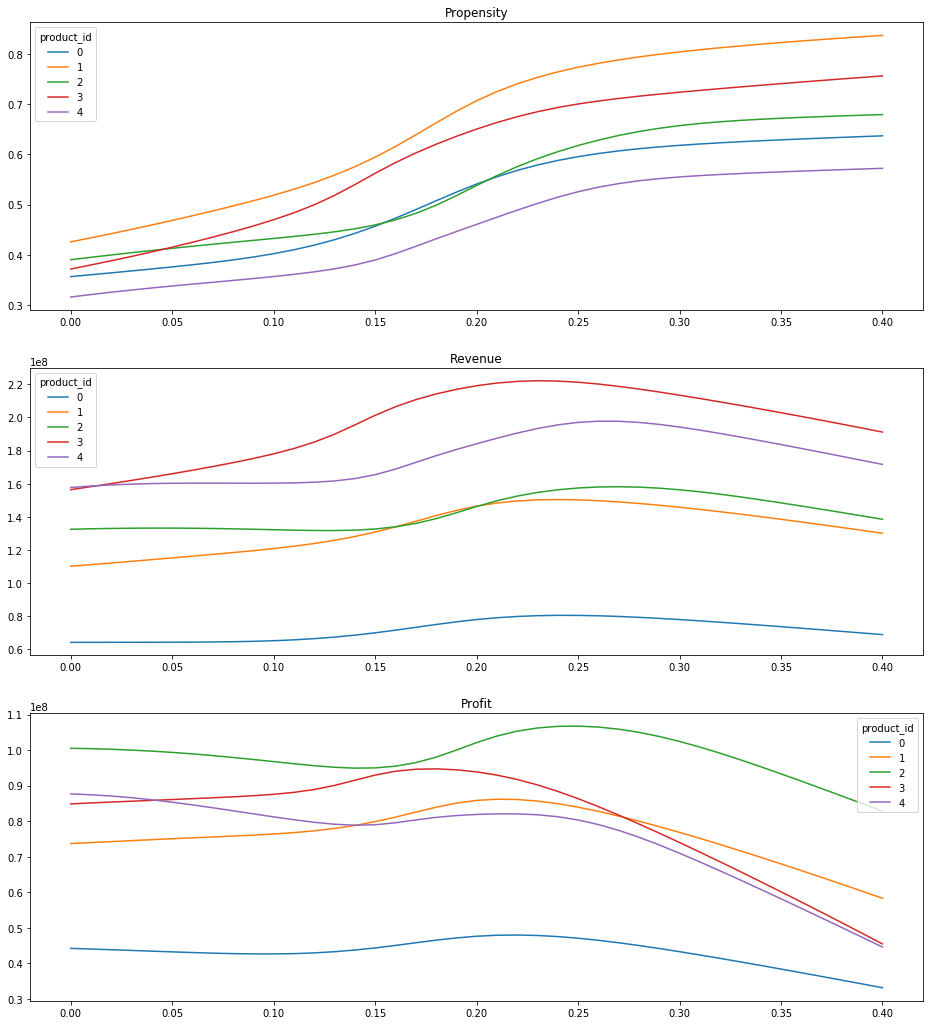

In [9]:
v_space = 0.01
f_discounts = np.arange(0, MAX_DISCOUNT + v_space, v_space)

cols_grpby = ['product_id']

scan_propensity = []
scan_revenue = []
scan_profit = []

for f in f_discounts:
    X = df[cols_x].values
    X[:, 0] = df['RRP']*f 
    col_discount = 'Discount_{:.02f}'.format(f)
    col_pred = 'y_pred_{:.02f}'.format(f)
    df.loc[:, col_discount] = X[:, 0]
    df.loc[:, col_pred] = model.predict_proba(X)[:, 1]
    
    # Prospensity
    s_prop = df.groupby(cols_grpby).apply(lambda df: np.mean(df[col_pred])).rename(f)
    s_reve = df.groupby(cols_grpby).apply(lambda df: np.dot(df['RRP'] - df[col_discount], df[col_pred])).rename(f)
    s_prof = df.groupby(cols_grpby).apply(lambda df: np.dot(df['RRP'] - df[col_discount] - df['Cost'], df[col_pred])).rename(f)

    scan_propensity.append(s_prop)
    scan_revenue.append(s_reve)
    scan_profit.append(s_prof)

f, ax = plt.subplots(3, 1, figsize=(16,18))
pd.concat(scan_propensity, axis=1).T.plot(ax = ax[0],  title='Propensity')
pd.concat(scan_revenue, axis=1).T.plot(ax = ax[1],  title='Revenue')
pd.concat(scan_profit, axis=1).T.plot(ax = ax[2],  title='Profit')